Welcome to MICP analyzer! This program can compare the trajectory differences of LDMP w/o MICP.
[['MLH', '36.8N', '122.5W'], ['SK1', '23.2N', '127.3E'], ['SK2', '12.1N', '141.8E'], ['SK3', '14.8N', '145.8E'], ['SY1', '13.5N', '87.3E'], ['SY2', '0.1N', '87.3E'], ['SY3', '13.5S', '87.3E'], ['DP1', '33.7N', '40.5W'], ['DP2', '34.4N', '36.2W'], ['EGIV', '78.8N', '2.8E'], ['N5', '79.9N', '3.1W'], ['HGIV', '79.1N', '4.2W'], ['HGIX', '79.1N', '2.8W']]
Please input the Latitude of the specify geographic location in:(e.g. 13.5N)
13.5N
Please input the Longtitude of the specify geographic location in:(e.g. 87.3E)
87.3S
Please input the date of oceangraphic data:(e.g. 20220628 or 20211208)
20211208
The longtitude input is wrong!!


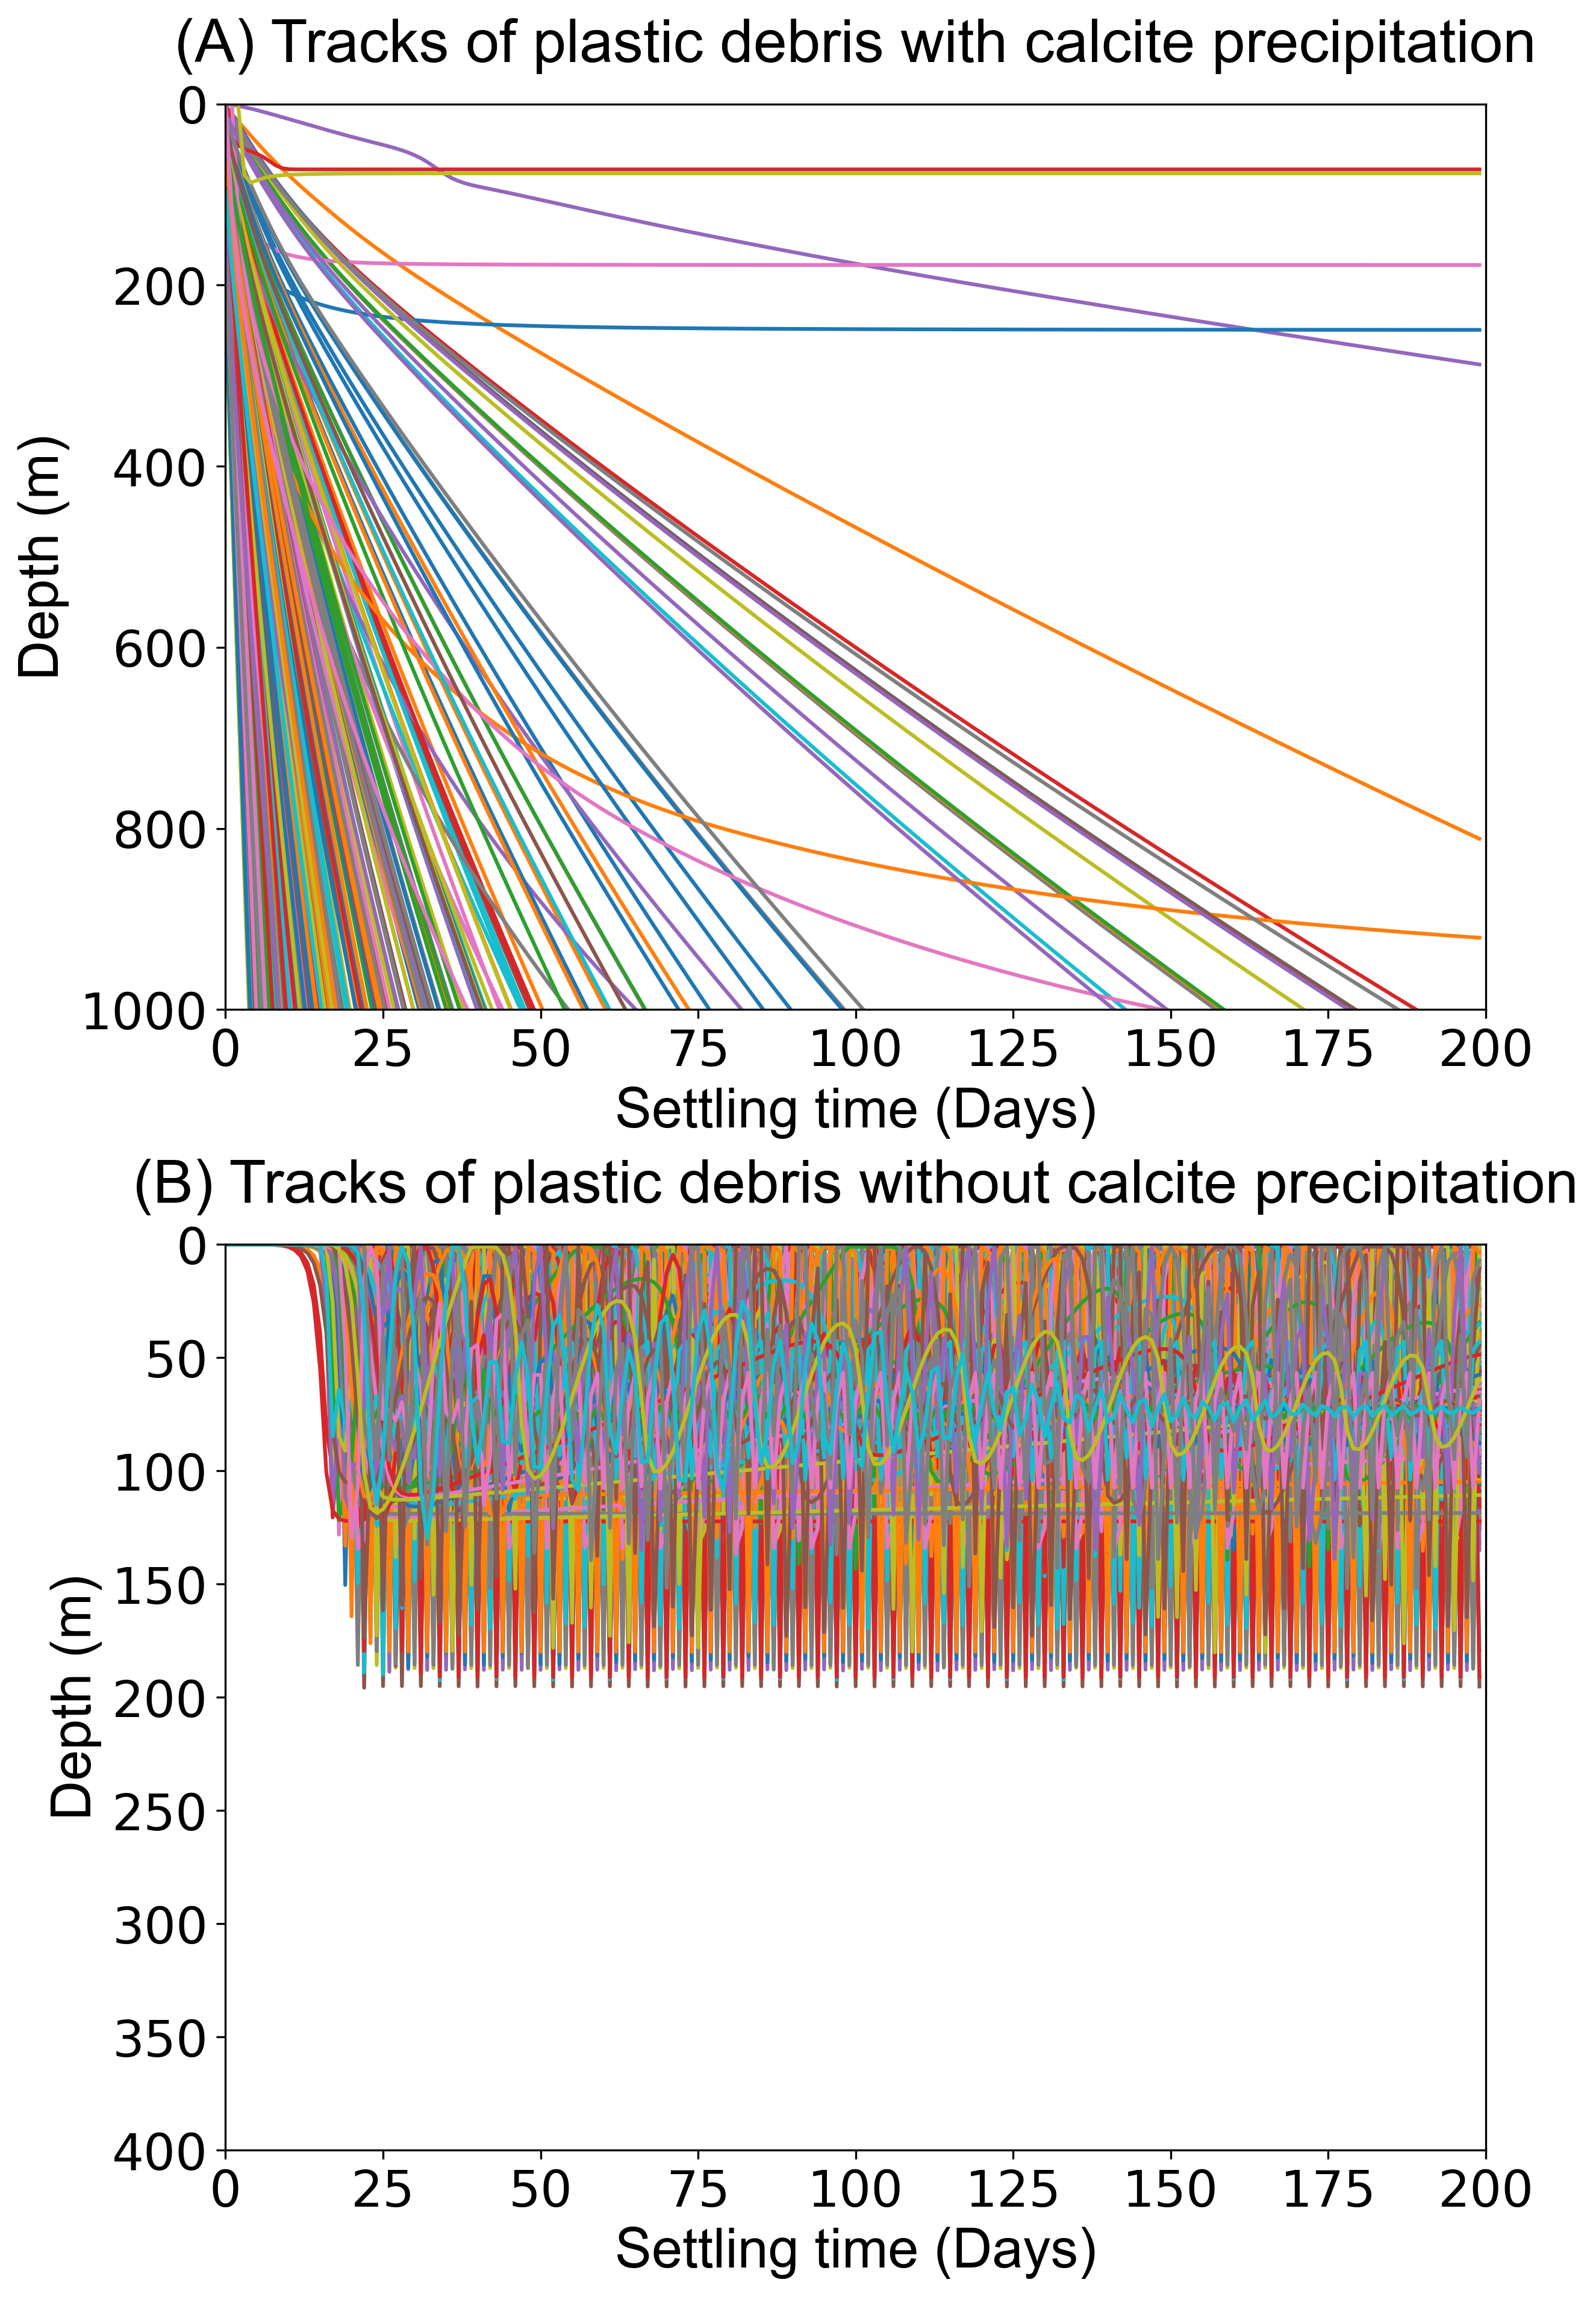

In [24]:
r"""
    This model primaryly estimates the vertical transport velocity for microplastics
    December 7th, 2022
    Code by Xiangfei Sun, Jinan University

    Please see the associated paper:
    Sun X., Zeng E.Y., Xie M., Mai L., Song X. 
    2022
    Microplastic Deposition in Ocean
    Science
"""

# Functional Package Import
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import netCDF4
import numpy.ma as ma
from pylab import *
import csv
import random
import copy
import matplotlib.colors as mcolors

# Data file reader

# .xlsx reader
def readexcel(file_name):
    
    data = pd.read_excel(file_name)
    train_data = np.array(data)  # np.ndarray()
    excel_list = train_data.tolist()  # list
    
    return excel_list

# .csv reader
def csvimport(file_name):
    
    smiles = []
    with open(file_name,'r',encoding='UTF-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:  
            smiles.append(row)
    smiles[0][0] = 'No.'
    
    return(smiles) 

def csvimport1(file_name):
    
    smiles = []
    with open(file_name) as csvfile:
        csv_reader = csv.reader(csvfile)  
        for row in csv_reader: 
            smiles.append(row)
    smiles[0][0] = 'No.'
    
    return(smiles) 

r"""
   The functions are defined for data import from .csv file (csvimport and csvimport1) 
   and .xlsx file (readexcel)
"""

# Random size generator
def exponential_rand(lam):
    if lam <= 0:    
        return -1
    u = random.random()  
    sign = 1
    while sign == 1:
        try:
            value = (-1.0/lam) * np.log(u)  
            sign = 0
        except:
            sign = 1        
    return value

# Gravity Adjustment according to Latitude
def local_g(lat,depth):
    
    A = 0.0053024
    B = 0.0000058
    C = 3.086e-06
    
    lat_value = float(lat[:-1])
    loc_g = 9.780327*((1+A*(math.sin(lat_value))**2-B*(math.sin(2*lat_value))**2)-C*(-depth))*3600**2*24**2
    
    return(loc_g)
    
    r"""
    Calculates local gravity at given Latitude and water depth.
 
    Parameters
    ----------
    lat : float
        Latitude in degree
    depth : float
        Seawater depth in minus meter
 
    Returns
    -------
    loc_g, the local gravity in m2/day
    
    References
    ----------
    International Gravity Formula, 2008, A Dictionary of Earth Sciences (3 ed.), 
    Oxford University Press.
    """
    
# Seawater Density according to depth, salinity, and temperature
def water_density(t,S):
    
    c1 = 9.999e02
    c2 = 2.034e-02
    c3 = -6.162e-03
    c4 = 2.261e-05
    c5 = -4.657e-08
    b1 = 8.020e02
    b2 = -2.001
    b3 = 1.677e-02
    b4 = -3.060e-05
    b5 = -1.613e-05
    
    den_f = c1 + c2*t + c3*t**2 + c4*t**3 + c5*t**4 + b1*S + b2*S*t + b3*S*t**2 + b4*S*t**3 + b5*(S**2)*(t**2) 
    value = den_f/1000
    
    return(value)

    r"""
    Calculates seawater density at given temperature and salinity
    using Eq. (8) given by Sharqawy et. al [1]. Values at temperature higher
    than the normal boiling temperature are calculated at the saturation
    pressure.
 
    Parameters
    ----------
    t : float
        Temperature must be in Celsius for this emperical equation to work
 
    S : float
        Salinity must be expressed in kg of salt per kg of solution (ppt).
 
    Returns
    -------
    value, the density of water/seawater in [kg/m3]
 
    Notes
    -----
    T must be in C, and S in g of salt per kg of phase, or ppt (parts per thousand)
    VALIDITY: 0 < T < 180 C; 0 < S < 0.16 kg/kg;
    ACCURACY: 0.1 %
 
    References
    ----------
    [1] Sharqawy M. H., Lienhard J. H., and Zubair, S. M., Desalination and
        Water Treatment, 2010.
    """
    
# Microplastic Shape, Size, and Weight
# 1. Sphere
def MP_sphere(r_pl):
    
    V_pl = 4*pi*(r_pl**3)/3
    S_pl = 4*pi*(r_pl**2)
    
    return (V_pl, S_pl)
    
    r"""
    Calculates dimensions, sizes, and volume of microplastics in near sphere shape.
    
    Parameters
    ----------
    r_pl : float
        The radius of original microplastic particle near to sphere shape in m.    

    Returns
    -------
    V_pl: float
        The volume of original microplastic particle near to sphere shape in m3.    
    S_pl: float
        The surface area of original microplastic particle near to sphere shape in m2.
    
    Notes
    ----------
    The microplastic particle, which is close to sphere shape, is assumed as a perfect 
    sphere to simplify the analysis. This function can be altered or adjusted for an 
    irregular sphere. However, it may require a simultaneous change for the shape factor 
    estimation according to real-time measurements or modeling assumptions.
    """

# 2. Film:
def MP_film(r_pl,t_pl):
    
    V_pl = pi*(r_pl**2)*t_pl
    S_pl = 2*pi*(r_pl**2) + 2*pi*r_pl*t_pl
    
    return (V_pl, S_pl) 

    r"""
    Calculates dimensions, sizes, and volume of microplastics in film shape.
    
    Parameters
    ----------
    r_pl : float
        The radius of the surface of original microplastic film in m.
    t_pl : float
        The thickness of original microplastic film in m.
        
    Returns
    -------
    V_pl: float
        The volume of original microplastic film in m3.    
    S_pl: float
        The surface area of original microplastic film in m2.
   
    Notes
    ----------
    The microplastic particle, which is close to fibrous shape, is assumed as a perfect 
    long cylinder to simplify the analysis. This function can be altered or adjusted for an 
    irregular or uneven cross-section. However, it may require a simultaneous change for the 
    shape factor estimation according to real-time measurements or modeling assumptions.
    """ 

# 3. Fiber:
def MP_fiber(r_pl,l_pl):
    
    V_pl = pi*(r_pl**2)*l_pl
    S_pl = 4*pi*(r_pl**2) + 2*pi*r_pl*l_pl
    
    return (V_pl, S_pl) 
    
    r"""
    Calculates dimensions, sizes, and volume of microplastics fiber.
    
    Parameters
    ----------
    r_pl : float
        The radius of the cross section of original microplastic fiber in m.
    l_pl : float
        The thickness of original microplastic in film shape in m.
        
    Returns
    -------
    V_pl: float
        The volume of original microplastic fiber in m3.    
    S_pl: float
        The surface area of original microplastic fiber in m2.
    
    Notes
    ----------
    The microplastic particle, which is close to thin film shape, is assumed as an even thickness 
    and a circular shape to simplify the analysis. This function can be altered or adjusted for an 
    irregular or uneven thickness. However, it may require a simultaneous change for the 
    shape factor estimation according to real-time measurements or modeling assumptions.
    """  
    
# The Enconunter Kernel Rate
def collision(d_ESD,T,k,r_A,w_v,Wt,shear):
    
    # 1 Bronian motion
    D_pl = k*(T+273.16)/(6*pi*w_v*d_ESD*0.5)
    D_A = k*(T+273.16)/(6*pi*w_v*r_A)
    Beta_BM = 4*pi*(D_pl+D_A)*(r_A+d_ESD/2)
    
    # 2 Differential settling
    Beta_DS = 0.5*pi*(0.5*d_ESD)**2*Wt
    
    # 3 Advective shear
    Beta_AS = 1.3*shear*(0.5*d_ESD+r_A)**3
    
    Beta_A = Beta_BM + Beta_DS + Beta_AS
    
    return Beta_A
    
    r"""
    Calculates the particle/algae encounter kernel rate at given temperature, seawater viscosity, 
    veritical speed, and shear using reference [1], [2], and [3]. 
    
    Parameters
    ----------
    T : float
        The seawater temperature at given depth in C.
    k : float
        The Boltzmann constant in m2 kg d-2 K-1.
    w_v : float
        The seawater viscosity at given depth in kg m-1 d-1.
    Wt : float
        The vertical transport speed at given depth in m d-1.
    shear: float
        The shear rate in day-1

    Returns
    -------
    Beta_A: float
        The enconunter kernal rate.
        
    References
    ----------
    [1] Jackson, G. A., A model of the formation of marine algal flocs by physical coagulation processes.
        Deep-Sea Res. I: Oceanogr. Res. 1990, 37, 1197-1211.
    [2] Burd, A. B.; Jackson, G. A., Particle aggregation. Annu. Rev. Mar. Sci. 2009, 1, 65-90.
    [3] Farley, K. J.; Morel, F. M. M., Role of coagulation in the kinetics of sedimentation. Environ. 
        Sci. Technol. 1986, 20, 187-195.
    """
    
# Selecting parameters for surface Chl_a concentraiton
def position_chl_a(Latitude,Longtiude,Lat_bins,Lon_bins,dataset):
    
    try:
        # Latitude Reposition
        identifier = Latitude[-1]
        lat_value = float(Latitude[:-1])
        if identifier == 'S':
            lat_value = -1*lat_value
        elif identifier == 'N':
            lat_value = lat_value
        else:
            print('The lattitude input is wrong!!')

        # Longtitude Reposition
        identifier = Longtitude[-1]
        lon_value = float(Longtitude[:-1])
        if identifier == 'E':
            lon_value = lon_value
        elif identifier == 'W':
            lon_value = -1*lon_value
        else:
            print('The longtitude input is wrong!!')
        
        posi_lat = np.digitize(lat_value, Lat_bins) - 1
        posi_lon = np.digitize(lon_value, Lon_bins) - 1
        
        chl_a = dataset[posi_lat,posi_lon]
    except:
        print("The given position is on land!  Calculation terminates!")
    
    return(chl_a)

    r"""
    Find the surface Chl_a concentraiton at given latitude and longtitude 
    using reference [1] provided by NASA. 
    
    Parameters
    ----------
    Latitude : string
        The latitude of the given position in degrees and orientation sign.
    Longtitude : string
        The longtitude of the given position in degrees and orientation sign.
    Lat_bins : float
        The latitude of given surface chlorophyll-a profile in degrees.
    Lon_bins : float
        The longtitude of given surface chlorophyll-a profile in degrees.
    dataset: float
        The surface chlorophyll-a concentration matrix in mg m-3.

    Returns
    -------
    chl_a: float
        The surface chlorophyll-a concentration in mg m-3.
        
    References
    ----------
    [1] NASA, Chlorophyll concentration, NASA earth observatory, 
        https://earthobservatory.nasa.gov/global-maps/MY1DMM_CHLORA. 
        (accessed Feb 2, 2022)
    """
    
# The chlorophyll-a concentration
def Chloro_a(parameter_list, chl_a_bins, chl_a, z):
    
    posi_chl_a = np.digitize(chl_a, chl_a_bins) - 1
    C_b = parameter_list[posi_chl_a][0]
    s = parameter_list[posi_chl_a][1]
    C_max = parameter_list[posi_chl_a][2]
    Z_max = parameter_list[posi_chl_a][3]
    delta_z = parameter_list[posi_chl_a][4]
    dep_eupz = parameter_list[posi_chl_a][9]
    Chl_a_base = parameter_list[posi_chl_a][5]
    Chl_a = (C_b-s*z/dep_eupz+C_max*exp(-((z-Z_max)/delta_z)**2))*Chl_a_base
    if Chl_a < 0:
        Chl_a = 0
    
    return Chl_a

    r"""
    Calculates the chlorophyll-a concentration at given depth based on references [1] and [2].
    
    Parameters
    ----------
    C_b : float
        The normalized surface concentration.
    s : float
        The slope in m-1.
    z: float
        The seawater depth in m.
    C_max: float
        The normalized maximum concentration.
    Z_max: float
        The depth at which the maximum concentration can be found in m.
    delta_z: float
        The width of the peak in m.
    Chl_a_base: float
        The average chlorophyll-a concentration of the vertical profile in mg m-3

    Returns
    -------
    Chl_a: float
        The chlorophyll-a concentration at depth z in mg m-3.
    
    Notes
    ----------
    Chl_a concentration must be a non-negative value.
    
    References
    ----------
    [1] Uitz, J.; Claustre, H.; Morel, A.; Hooker, S. B., Vertical distribution of 
        phytoplankton communities in open ocean: An assessment based on surface chlorophyll.
        J. Geophys. Res. Oceans 2006, 111.
    [2] Ardyna, M.; Babin, M.; Gosselin, M.; Devred, E.; Bélanger, S.; Matsuoka, A.; 
        Tremblay, J. É., Parameterization of vertical chlorophyll a in the Arctic Ocean: 
        Impact of the subsurface chlorophyll maximum on regional, seasonal, and annual primary 
        production estimates. Biogeosciences 2013, 10, 4383-4404.
    """    
    
# Algae concentraition at given depth z
def algae_c(Chl_a,T,L_z,V_A):
    
    C_conc = Chl_a / (0.003+1.0154*exp(0.05*T)*exp(-0.059*L_z/10**6))
    A_conc = C_conc*10**9 / (0.216*((V_A*10**18)**0.939))
    
    return A_conc,C_conc

    r"""
    Calculates the algae concentration at given depth according to chlorophyll-a concentration
    and carbon ratio given by reference [1] and [2].
    
    Parameters
    ----------
    Chl_a : float
        The vertical chlorophyll-a profile at given depth z in mg m-3.
    T : float
        The temperature at given depth in C.
    L_z : float
        The light intensity at given depth z in (uE m-2 day-1).
    V_A: float
        The algae volume in m3.

    Returns
    -------
    C_conc: float
        The carbon concentration in mg m-3
    A_conc: float
        The algae concentration at given temperature and light intensity L_z in cell m-3.    
    
    References
    ----------
    [1] Cloern, J. E.; Grenz, C.; Vidergar-Lucas, L., An empirical model of the phytoplankton 
        chlorophyll: carbon ratio-the conversion factor between productivity and growth rate. 
        Limnol. Oceanogr. 1995, 40, 1313-1321.
    [2] Menden-Deuer, S.; Lessard, E. J., Carbon to volume relationships for dinoflagellates, 
        diatoms, and other protist plankton. Limnol. Oceanogr. 2000, 45, 569-579.
    """ 
    
# Light intensity
def light_intensity(z,Chl_a,o_w,o_p,t_ac,I_m,Latitude):
    
    o_t = o_w + o_p * Chl_a
    I_0 = I_m * sin(2*t_ac*pi)
    if I_0 < 0:
        I_0 = 0
    L_z = I_0 * exp(-o_t*z)
    if L_z < 0:
        L_z = 0
        
    return L_z, o_t

    r"""
    Calculates the light intensity at given depth and time based on the law of Lambert-Beer.
    
    Parameters
    ----------
    z : float
        Seawater depth in m.
    Chl_a : float
        The vertical chlorophyll-a profile at given depth z in mg m-3.
    o_w : float
        The extinction coefficients for water.
    o_p : float
        The extinction coefficients for chhlorophyll.
    t: float
        The time spot.
    I_m: float
        The light intensity at noon (uE m-2 day-1)

    Returns
    -------
    L_z: float
        The light intensity at given depth z in (uE m-2 day-1).
    
    """ 
    
# Algae Growth
def algae_growth(L_z,u_max,I_opt,alpha,T,T_max,T_min,T_opt):
    
    u_opt = u_max*L_z/(L_z+u_max*(L_z/I_opt-1)**2/alpha)
    fy_T = ((T-T_max)*(T-T_min)**2)/((T_opt-T_min)*((T_opt-T_min)*(T-T_opt)-(T_opt-T_max)*(T_opt+T_min-2*T)))
    A_g = u_opt * fy_T
    
    return A_g

    r"""
    Calculates the algae growth rate at given depth and temperature based on reference [1].
    
    Parameters
    ----------
    L_z : float
        The light intensity at given depth z in uE m-2 day-1.
    u_max : float
        The maximum growth rate under optimal conditions in day-1.
    I_opt : float
        The optimal light intensity for algae growth uE m-2 day-1. 
    alpha : float
        The initial slope in day-1.
    T: float
        The temperature at depth z in C.
    T_max: float
        The maximum temperature to sustain algae growth in C.
    T_min: float
        The minimum temperature to sustain algae growth in C.
    T_opt: float
        The optimal temperature to sustain algae growth in C.      

    Returns
    -------
    A_g: float
        The algae growth rate in day-1.
    
    References
    ----------
    [1] Bernard, O.; Rémond, B., Validation of a simple model accounting for light and temperature
        effect on microalgal growth. Bioresour. Technol. 2012, 123, 520-527.
    """ 
    
# The Biofilm development rate
def biofilm_growth(S_pl, A_g, A_conc, Beta_A, m_A, T, Q_10, R_20, A, phy_att):
    
    B_g = Beta_A*A_conc/S_pl*phy_att + A_g*A - m_A*A - Q_10**((T-20)/10)*A*R_20
    
    return B_g   
    
    r"""
    Calculates the biofilm development rate at given depth and temperature.
    
    Parameters
    ----------
    A_g : float
        The algae growth rate in day-1.
    A_conc : float
        The algae concentration at given temperature and light intensity L_z in cell m3.
    S_pl : float
        The surface area of original microplastic film in m2.
    Beta_A : float
        The enconunter kernal rate in m3 day-1.
    m_A: float
        The mortality rate in day-1.
    T: float
        The temperature at depth z in C.
    Q_10: float
        The respiration coefficient.
    R_20: float
        The respiration rate of algae in day-1.
    A: float
        Current algae attached on microplatic surface in cell m-2.

    Returns
    -------
    B_g: float
        The biofilm growth rate in cell m-2 day-1.
    """  
    
# The biofirm volume
def bio_volume(B_g, V_A, t, A, S_pl):

    A = A + B_g * t
    V_bf = A * V_A * S_pl
        
    return V_bf,A

    r"""
    Calculates the biofilm volume on microplastic at given depth and temperature.
    
    Parameters
    ----------
    V_A : float 
        The volume of single algae in m3. 
    S_pl : float
        The microplastic surface area in m2.
    A : float
        The number of algae in cell m-2.    
    V_M : float
        The volume of minerals on microplastics particle in m3. 
    t: float
        The time length in days.

    Returns
    -------
    V_bf: float
        The accumulated volume of algae in the biofirm in m3.
        
    Notes
    -------
    The algae volume is a non-negative value.
    """ 
    
# The mineral growth
def minal_volume(Ca_g,L_z,I_m,t,m_b,dep,V_A,A,S_pl):
    
    # Calcite precipitation caused by photosynthesis
    m_b = 0.5*Ca_g*3600*24*L_z/I_m/10**6*100/1000*S_pl*t+m_b
    if dep > 1000:
        m_b = m_b-0.0002*0.001*S_pl*t
    if m_b < 0:
        m_b = 0
    
    # Calcite precipitation based on photosynthesis 
    V_M = m_b/2630
    
    return m_b, V_M
    
    r"""
    Calculates the calcium precipitation rate on microplastic at given depth based on 
    references [1] -- [4], assuming seafloor is always above the calcite compensation depth.
    
    Parameters
    ----------
    Ca_g : float 
        The calcite precipitation rate in umol m-2 s-1        
    dep : float
        The seawater depth in m.    
    o_t : float
        The coefficient for light reduction. 
    t: float
        The time length in days.
    m_b : float
        The previous mineral build-ups in kg.
    V_A : float
        The algae volume in m3.
    A : float
        Number of algae attached on microplastic surface in No.

    Returns
    -------
    m_b : float
        The accumulated mass of calcite in the biofirm in kg.
    V_M : float
        The voulume current mineral build-ups in m3.  
        
    References
    ----------
    [1] Dong, S.; Subhas, A. V.; Rollins, N. E.; Naviaux, J. D.; Adkins, J. F.; Berelson, 
        W. M., A kinetic pressure effect on calcite dissolution in seawater. Geochim. 
        Cosmochim. Acta 2018, 238, 411-423.
    [2] Šovljanski, O.; Pezo, L.; Tomić, A.; Ranitović, A.; Cvetković, D.; Markov, S., 
        Contribution of bacterial cells as nucleation centers in microbiologically induced 
        CaCO3 precipitation—A mathematical modeling approach. J. Basic Microbiol. 
        2021, 61, 835-848.
    [3] Price, N. N.; Hamilton, S. L.; Smith, J. E.; Tootell, J. S., Species-specific 
        consequences of ocean acidification for the calcareous tropical green algae Halimeda.
        In Mar. Ecol. Prog. Ser., PANGAEA: 2011; Vol. 440, pp 67-78.
    [4] Hartley, A. M.; House Wa Fau - Leadbeater, B. S. C.; Leadbeater Bsc Fau - Callow, M. E.;
        Callow, M. E., The use of microelectrodes to study the precipitation of calcite upon algal 
        biofilms. J. Colloid Interface Sci. 1996, 183, 498-505.
    """ 
    
# Microplastic volume with included biofilm
def total_volume(V_M, V_bf, V_pl):
    
    V_T = V_pl + V_bf + V_M
    
    return V_T

    r"""
    Calculates the total volume of microplastic inclusion in m3
    
    V_M : float
        The volume of minerals on microplastics particle in m3. 
    V_pl : float
        The microplastic volume in m3.
    V_bf: float
        The volume of biota on microplastic inclusion in m3.
        
    Returns
    -------
    V_T : float
        The total volume of inclusion in m3.
    """
    
# The equavalent sphaerical diameter
def ESD(V_T):
    
    d_ESD = (3*V_T/(4*pi))**(1/3)*2
    
    return d_ESD

    r"""
    Calculates the equavalent sphaerical diameter (ESD) in m.
    
    Parameters
    ----------
    V_T : float
        The total volume of inclusion in m3.
        
    Returns
    -------
    d_ESD: float
        The equavalent sphaerical diameter (ESD) in m.  
    
    References
    ----------
    [1] Van Melkebeke, M.; Janssen, C.; De Meester, S., Characteristics and sinking behavior of 
        typical microplastics including the potential effect of biofouling: implications for 
        remediation. Environ. Sci. Technol. 2020, 54, 8668-8680.
    [2] Dioguardi, F.; Mele, D.; Dellino, P., A new one-equation model of fluid drag for irregularly 
        shaped particles valid over a wide range of reynolds number. J. Geophys. Res. Solid Earth, 
        2018, 123, 144-156.
    """
    
# The shape factor
#1. Sphere
def shape_factor_sphere():
    
    X = 1
    Theta = 1
    shape_f = Theta/X
    
    return shape_f

#2. Fiber
def shape_factor_fiber(V_T,l_pl):
    
    r_T = ((V_T/l_pl)/pi)**0.5
    S_p = r_T*2*l_pl*pi + 2*pi*r_T**2
    r_sp = (3*V_T/(4*pi))**(1/3)
    S_sp = 4*pi*r_sp**2
    Theta = S_sp / S_p
    P_p = (r_T*2+l_pl)*2
    S_proj = 2*r_T*l_pl
    r_proj = (S_proj/pi)**0.5
    P_proj = 2*pi*r_proj
    X = P_p/P_proj
    shape_f = Theta/X
    
    return shape_f
    
#3. Film
def shape_factor_film(V_T,r_film):
    
    t_T = V_T/(pi*r_film**2)
    S_p = r_film*2*t_T*pi + 2*pi*r_film**2
    r_sp = (3*V_T/(4*pi))**(1/3)
    S_sp = 4*pi*r_sp**2
    Theta = S_sp / S_p
    S_proj = r_film**2*pi*0.5
    r_proj = (S_proj/(pi))**0.5
    P_proj = 2*pi*r_proj
    P_p = 2*pi*r_film
    X = P_p/P_proj
    shape_f = Theta/X
    
    return shape_f  

    r"""
    Calculates the shape factor of microplastic particle during vertical movement.
    
    Parameters
    ----------
    V_T : float
        The total volume of inclusion in m3.
    l_pl : float
        The length of fiber in m.   
    t_pl : float
        The thickness of film in m.
    
    Returns
    -------
    Theta : float
        The sphericity
    X : float
        The circularity
    shape_f : float
        The shape factor of the inculusion.
        
    Notes
    ----------
    [1] The sphericity is never greater than 1, being 1 for a perfect sphere.
    [2] The circularity is never smaller than 1, being 1 for a perfect circular contour.
    [3] The shape factor is never greater than 1, being 1 for a perfect sphere.
    [4] The shape factor is specifically designed for the vertical velocity calculation 
        formula of Eq. 14 given in reference [1].
    
    References
    ----------
    [1] Dioguardi, F.; Mele, D.; Dellino, P., A new one-equation model of fluid drag for irregularly
        shaped particles valid over a wide range of reynolds number. J. Geophys. Res. Solid Earth, 
        2018, 123, 144-156.
    """
    
# The microplastic inclusion density
def mp_in_density(V_T,den_pl,den_A,m_b,V_bf,V_pl):
    
    in_den = (V_pl*den_pl + V_bf*den_A + m_b)/V_T
    
    return in_den

    r"""
    Calculates the shape factor of vertical movement.
    
    Parameters
    ----------
    V_T : float
        The total volume of inclusion in m3.
    V_pl : float
        The microplastic volume in m3.
    den_pl : float
        The miroplastic density in kg/m3.
    den_A : float
        The algae density in kg/m3.
    m_b : float
        The accumulated mineral mass in kg.
    V_bf : float
        The current biofilm volume in m3.
    
    Returns
    -------
    in_den : float
        The microplastic inclusion density in kg m-3.
    """
    
# Seawater Viscosity
def water_viscosity(pore_T,pore_salinity):
    
    T = pore_T
    try:
        S = pore_salinity
    except:
        S = 0
    TC = T
    S = S/1000
    a1 = 1.5700386464E-01
    a2 = 6.4992620050E+01
    a3 = -9.1296496657E+01
    a4 = 4.2844324477E-05
    mu_w = a4 + 1/(a1*(TC+a2)**2+a3)
    a5 = 1.5409136040E+00
    a6 = 1.9981117208E-02
    a7 = -9.5203865864E-05
    a8 = 7.9739318223E+00
    a9 = -7.5614568881E-02
    a10 = 4.7237011074E-04
    A = a5 + a6*T + a7*T**2
    B = a8 + a9*T + a10*T**2
    mu_sw = mu_w*(1 + A*S + B*S**2)
    value = mu_sw * 3600 * 24
    
    return value

    r"""
    Calculates viscosity of pure water or seawater at atmospheric pressure
    using Eq. (22-23) given by Sharqawy et. al [1]. Values at temperature higher
    than the normal boiling temperature are calculated at the saturation
    pressure.
    
    Parameters
    ----------
    pore_temperature : float
        Temperature must be in Celsius for this emperical equation to work 
    pore_salinity : float
        Salinity must be expressed in kg of salt per kg of solution (ppt).
 
    Returns
    -------
    mu_sw, the viscosity of water/seawater in kg m-1 day-1.
 
    Notes
    -----
    T must be in C, and S in g of salt per kg of phase, or ppt (parts per thousand)
    VALIDITY: 0 < T < 180 C; 0 < S < 150 g/kg;
    ACCURACY: 1.5 %
 
    References
    ----------
    [1] Sharqawy M. H., Lienhard J. H., and Zubair, S. M., Desalination and
        Water Treatment, 2010.
    """
    
# Vertical settlement velocity solver
def vertical_velocity(shape_f,den_f,in_den,g,d_p,u_f,dep):
    
    # Set initial tolerance and guess of Reynolds number for solver
    tolerance = 1
    Re = 10
    
    # Calculating the vertical settlement velocity
    if dep > 0:
        if in_den > den_f:
            while tolerance > 0.01:
                # Update current Reynolds number
                init_Re = Re 
                # Calculating partical drag coefficient using Dioguardi et al., 2018
                Cd = 24/Re*((1-shape_f)/Re+1)**0.25+24/Re*(0.1806*Re**0.6459)/(shape_f**(Re**0.08))+0.4251/(1+6880.95/Re*shape_f**5.05) 
                # Calculating settling velocity
                Wt = (4*g*(in_den-den_f)*d_p/(3*Cd*den_f))**0.5
                # Calculating Reynolds number
                Re = den_f*Wt*d_p/u_f
                # Estimating the new tolerance value under current result
                tolerance = abs(init_Re-Re)/Re
        else:
            while tolerance > 0.01:
                # Update current Reynolds number
                init_Re = Re 
                # Calculating partical drag coefficient using Dioguardi et al., 2018
                Cd = 24/Re*((1-shape_f)/Re+1)**0.25+24/Re*(0.1806*Re**0.6459)/(shape_f**(Re**0.08))+0.4251/(1+6880.95/Re*shape_f**5.05) 
                # Calculating settling velocity
                Wt = (4*g*(den_f-in_den)*d_p/(3*Cd*den_f))**0.5
                # Calculating Reynolds number
                Re = den_f*Wt*d_p/u_f
                # Estimating the new tolerance value under current result
                tolerance = abs(init_Re-Re)/Re
            Wt = -1 * Wt
    else:
        if in_den > den_f:
            while tolerance > 0.01:
                # Update current Reynolds number
                init_Re = Re 
                # Calculating partical drag coefficient using Dioguardi et al., 2018
                Cd = 24/Re*((1-shape_f)/Re+1)**0.25+24/Re*(0.1806*Re**0.6459)/(shape_f**(Re**0.08))+0.4251/(1+6880.95/Re*shape_f**5.05) 
                # Calculating settling velocity
                Wt = (4*g*(in_den-den_f)*d_p/(3*Cd*den_f))**0.5
                # Calculating Reynolds number
                Re = den_f*Wt*d_p/u_f
                # Estimating the new tolerance value under current result
                tolerance = abs(init_Re-Re)/Re
        else:          
            Wt = 0
            Re = Re
            Cd = 0
            
    return(Re, Wt, Cd)

    r"""
    Calculates settling velocity of microplastics with specific density in seawater Eq. (2),(3),(14) 
    given by Dioguardi et al. 2018  
    
    Parameters
    ----------
    shape : float
        The shape factor is a dimensionless parameter to describe the ratio between sphericity and circularity.
    den_f : float 
        The density of seawater in kg m-3.        
    in_den : float
        The density of paricles in kg m-3.       
    g : float
        The gravitational acceleration in m day-2.       
    d_p: float
        The particle size in m.      
    u_f: float
        The seawater viscosity in Pa*day.
    
    Returns
    -------
    Re : float
        The Reynolds number.
    Wt : float
        The particle settling velocity in m day-1.
    Cd : float
        The particle drag coefficient.
 
    Notes
    -----
    R2: 96.0% 
    
    References
    ----------
    [1] Dioguardi, F.; Mele, D.; Dellino, P., A new one-equation model of fluid drag for irregularly
        shaped particles valid over a wide range of reynolds number. J. Geophys. Res. Solid Earth, 
        2018, 123, 144-156.
    [2] Van Melkebeke, M.; Janssen, C.; De Meester, S., Characteristics and sinking behavior of typical 
        microplastics including the potential effect of biofouling: implications for remediation. 
        Environ. Sci. Technol. 2020, 54, 8668-8680.
    """
    
def cal_given_posi(Latitude,Longtiude,date,tolerance):
    
    # Latitude Reposition
    identifier = Latitude[-1]
    lat_value = float(Latitude[:-1])
    if identifier == 'S':
        lat_value = -1*lat_value
    elif identifier == 'N':
        lat_value = lat_value
    else:
        print('The lattitude input is wrong!!')

    # Longtitude Reposition
    identifier = Longtiude[-1]
    lon_value = float(Longtiude[:-1])
    if identifier == 'E':
        if lon_value > 74.16:
            lon_value = lon_value
        else:
            lon_value = lon_value + 360
    elif identifier == 'W':
        lon_value = 360 - lon_value
    else:
        print('The longtitude input is wrong!!')
           
    # Data import
    url = './Data/' + date + '_rtofs_glo_3dz_n024_daily_3ztio.nc'
    file = netCDF4.Dataset(url)
    lat  = file.variables['Latitude'][:]
    lon  = file.variables['Longitude'][:]
    dep = file.variables['Depth'][:]
    file.close()
    
    for i in range(3298):
        for j in range(4500):
            lat_diff = abs(lat[i,j] - lat_value)
            lon_diff = abs(lon[i,j] - lon_value)
            new_diff = (lat_diff**2 + lon_diff**2)**0.5
            if new_diff < tolerance:
                posi_lat = i
                posi_lon = j
            else:
                continue
                
    # Data import
    url = './Data/' + date + '_rtofs_glo_3dz_n024_daily_3ztio.nc'
    file = netCDF4.Dataset(url)

    # Extract data from given location
    temp = file.variables['temperature'][0,:,posi_lat,posi_lon]
    file.close()

    # Data import
    url = './Data/' + date + '_rtofs_glo_3dz_n024_daily_3stio.nc'
    file = netCDF4.Dataset(url)

    # Extract data from given location
    sat = file.variables['salinity'][0,:,posi_lat,posi_lon]
    file.close()

    Sea_den = []
    for i in range(len(sat)):
        try:
            new_point = water_density(temp.data[i],sat.data[i]/1000)
            if new_point > 0 and new_point < 1.2:
                Sea_den.append(new_point)
            else:
                continue
        except:
            continue
    Sea_den = np.array(Sea_den)    
    
    return(Sea_den,sat,temp)

    r"""
    Localize the given latitude and longtitude on the RTOFS datasets and extract the vertical profiles of 
    seawater temperature and salinity at given date. Calculate the seawater density profiles accordingly.
    
    Parameters
    ----------
    Latitude : string
        The proposed Latitude in degrees with orientation.
    Longtitude : string
        The proposed Longtiude in degrees with orientation.
    date : float
        The proposed date.       
    tolerance : float
        The difference between proposed location and avaliable data points. 
    
    Returns
    -------
    Sea_den : float
        The vertical seawater density at given location in kg m-3.
    sat : float
        The vertical seawater salinity at given location in ppt.
    temp : float
        The vertical seawater temperature at given location in C.
    """
    
# Density, Salinity and Temperature at given depth
def position(dep,bins,Sea_den,sat,temp):
    
    posi_depth = max_depth_check(sat) - 1
    max_depth = bins[posi_depth]
    if dep < max_depth:
        cats = np.digitize(dep, bins)
        posi_den = Sea_den[cats] - (Sea_den[cats] - Sea_den[cats-1])/(bins[cats] - bins[cats-1])*(bins[cats]-dep)
        posi_sat = sat[cats] - (sat[cats] - sat[cats-1])/(bins[cats] - bins[cats-1])*(bins[cats]-dep)
        posi_temp = temp[cats] - (temp[cats] - temp[cats-1])/(bins[cats] - bins[cats-1])*(bins[cats]-dep)
        sign = 0
    else:
        sign = 0
        #print("The maximum depth is apporached, which is: " + str(max_depth) + 'm at given location.')
        posi_den = Sea_den[posi_depth]
        posi_sat = sat[posi_depth]
        posi_temp = temp[posi_depth]
        dep = max_depth
        
    return(sign, posi_den, posi_sat, posi_temp, dep)

    r"""
    Calculate density, sanlinity, and temperature at given depth with last known position and vertical settling velocity.
    
    Parameters
    ----------
    dep : float
        The current depth in m.
    Sea_den : float
        The vertical profiles of seawater density in kg m-3.
    sat : float
        The vertical profiles of seawater salinity in ppt.   
    temp : float
        The vertical profiles of seawater temperature in ppt.
    bins : float
        The given depth in m.
    
    Returns
    -------
    sign : float
        The value which indicates whether the particle approaches the seafloor.
    posi_den : float
        The surrounding seawater density at given depth in m.
    posi_temp : float
        The surrounding seawater temperature at given depth in C.
    posi_sat : float
        The surrounding seawater salinity at given depth in ppt.
    dep : float
        The fixed depth in m.
    
    Notes
    -------
    The depth never excceds the maximum avaliable seawater depth at given location.
    """
    
# Check maximum depth at given locaiton
def max_depth_check(sat):
    
    count = 0
    for i in range(len(sat.data)):
        if sat.data[i] < 1.2676506e+30:
            count = count + 1
        else:
            break
            
    return count

    r"""
    Estimate the maximum seawater depth at given location.
    """
    
def evaluation_same_volume(r_pl,t_pl,l_pl):
    # Given the same size with different shape
    V_pl = 4/3*pi*r_pl**3
    r_fiber = (V_pl/l_pl/pi)**0.5
    r_film = (V_pl/t_pl/pi)**0.5
    return(r_fiber,r_film)

# Regulate Particle Generator
def regulate_mp_pro(shape_type,Latitude,r_pl,shape_factor):
    base_inf = []
    Lat = float(Latitude[:-1])  
    den_pl = 920
    time_len = 200
    shape_f = 1
    l_pl = random.randrange(57,13000)*0.000001
    t_pl = random.randrange(1,1000000)*0.00000001 
    
    if shape_type == 'fiber' or shape_type == 'film':
        while abs(shape_factor - shape_f) > 0.005:
            l_pl = random.randrange(57,13000)*0.000001
            t_pl = random.randrange(1,1000000)*0.00000001
            if shape_type == 'fiber':
                r_fiber,r_film = evaluation_same_volume(r_pl,t_pl,l_pl)
            elif shape_type == 'film':
                r_fiber,r_film = evaluation_same_volume(r_pl,t_pl,l_pl)

            if shape_type == 'fiber':
                V_pl, S_pl = MP_fiber(r_fiber,l_pl)
                V_T = V_pl
                shape_f = shape_factor_fiber(V_T,l_pl)   
            elif shape_type == 'film':
                V_pl, S_pl = MP_film(r_film,t_pl)
                V_T = V_pl
                shape_f = shape_factor_film(V_T,r_film)
    else:
        V_pl, S_pl = MP_sphere(r_pl)
        V_T = V_pl
        shape_f = 1
                
    base_inf.append(shape_type)
    base_inf.append(Lat)
    base_inf.append(r_pl)
    base_inf.append(l_pl)
    base_inf.append(t_pl)
    base_inf.append(V_pl)
    base_inf.append(S_pl)
    base_inf.append(V_T)
    base_inf.append(shape_f)
    base_inf.append(den_pl)
    base_inf.append(time_len)
    return base_inf

def monte_carlo_MP(num_mp,Ca_g,Latitude,Longtitude,te,Sea_den,sat,temp,dataset,Lat_bins,Lon_bins,parameter_list):
    
    Lat = float(Latitude[:-1])
    den_A = 1176
    V_A = 1e-15
    m_A = 0.39
    R_20 = 0.1
    k = 1.0306e-013
    Q_10 = 2
    u_max = 1.85
    alpha = 0.12
    T_min = 0.2
    T_opt = 26.7
    T_max = 33.3
    I_opt = 1.75392e13
    t = 0.001
    o_w = 0.2
    o_p = 0.02
    I_m = 1.2e08
    bins = np.array([0.,10.,20.,30.,50.,75.,100.,125.,150.,200.,250.,300.,400.,500.,600.,700.,800.,900.,1000.,1100.,
                     1200.,1300.,1400.,1500.,1750.,2000.,2500.,3000.,3500.,4000.,4500.,5000.,5500.])
    shear = 1.7e05
    r_A = (3*V_A/(4*pi))**(1/3)
    chl_a_bins = np.array([0,0.04,0.08,0.12,0.2,0.3,0.4,0.8,2.2,4])
      
    dep_record = []
    result = []
    tracks = []
    
    day_len = int(1/t)

    for i in range(num_mp):
        new_track = []
        count = 1
        n = random.random()
        phy_att = 0.3
        dep = 0
        W_t = 0
        m_b = 0
        if n < 0.33:
            shape_type = 'fiber'
        elif n >= 0.33 and n < 0.66:
            shape_type = 'film'
        else:
            shape_type = 'sphere'
        r_pl = (exponential_rand(5.5)*1000)*0.000001*0.5
        l_pl = random.randrange(100,13000)*0.000001
        t_pl = random.randrange(1,1000000)*0.00000001
        den_pl = random.randrange(850,1000)
        if shape_type == 'sphere':
            V_pl, S_pl = MP_sphere(r_pl)
            V_T = V_pl
            shape_f = random.randrange(9,10)*0.1  
        elif shape_type == 'fiber':
            r_fiber,r_film = evaluation_same_volume(r_pl,t_pl,l_pl)
            V_pl, S_pl = MP_fiber(r_fiber,l_pl)
            V_T = V_pl
            shape_f = shape_factor_fiber(V_T,l_pl)   
        elif shape_type == 'film':
            r_fiber,r_film = evaluation_same_volume(r_pl,t_pl,l_pl)
            V_pl, S_pl = MP_film(r_film,t_pl)
            V_T = V_pl
            shape_f = shape_factor_film(V_T,r_film)  
        V_bf = 0
        V_M = 0
        d_ESD = ESD(V_pl)
        sign, posi_den, posi_sat, posi_temp, dep = position(dep,bins,Sea_den,sat.data,temp.data)
        w_v = water_viscosity(posi_temp,posi_sat)
        Beta_A = collision(d_ESD,posi_temp,k,r_A,w_v,W_t,shear)
        A = 0
        sign = 0
        t_total = 0
        time_lenth = te
        round_sim = int(time_lenth/t)
        t_ac = 0
        chl_a = position_chl_a(Latitude,Longtitude,Lat_bins,Lon_bins,dataset)
        if chl_a > 4:
            chl_a = 3.9
        
        while sign == 0 and t_total < round_sim:
            sign, posi_den, posi_sat, posi_temp, dep = position(dep,bins,Sea_den,sat.data,temp.data)
            Chl_a = Chloro_a(parameter_list, chl_a_bins, chl_a, dep)
            L_z, o_t = light_intensity(dep,Chl_a,o_w,o_p,t_ac,I_m,Lat)
            A_conc,C_conc = algae_c(Chl_a,posi_temp,L_z,V_A)
            A_g = algae_growth(L_z,u_max,I_opt,alpha,posi_temp,T_max,T_min,T_opt)
            w_v = water_viscosity(posi_temp,posi_sat)
            Beta_A = collision(d_ESD,posi_temp,k,r_A,w_v,W_t,shear)
            B_g = biofilm_growth(S_pl, A_g, A_conc, Beta_A, m_A, posi_temp, Q_10, R_20, A, phy_att)
            m_b, V_M = minal_volume(Ca_g,L_z,I_m,t,m_b,dep,V_A, A, S_pl)
            V_bf, A = bio_volume(B_g, V_A, t, A, S_pl)
            V_T = total_volume(V_M, V_bf, V_pl)
            m_pl = V_pl * den_pl
            m_bf = V_bf * den_A
            d_ESD = ESD(V_T)
            if shape_type == 'sphere':
                S_pl = 4*(((3*V_T/(4*pi))**(1/3))**2)*pi
            elif shape_type == 'fiber':
                shape_f = shape_factor_fiber(V_T,l_pl)
                S_pl = 2*pi*((V_T/l_pl*pi)**(1/2))*l_pl
            elif shape_type == 'film':
                shape_f = shape_factor_film(V_T,r_pl)
            g = local_g(Latitude,dep)
            in_den = mp_in_density(V_T,den_pl,den_A,m_b,V_bf,V_pl)
            Re, Wt, Cd = vertical_velocity(shape_f,posi_den*1000,in_den,g,d_ESD,w_v,dep)
            if in_den < posi_den*1000 and int(dep) == 0:
                Wt = 0
            dep = dep + Wt*t
            posi_depth = max_depth_check(sat) - 1
            max_depth = bins[posi_depth]
            if dep < 0:
                dep = 0
                Wt = 0
            elif dep > max_depth:
                dep = max_depth
                Wt = 0
            elif np.isnan(dep):
                dep = dep_record[-1] + 0.001  
            t_ac = t_ac + t
            t_total = t_total + 1
            
            if count == day_len:
                new_track.append(dep)
                count = 1
            else:
                count = count + 1 
                
        tracks.append(new_track)
        dep_record.append(dep)
        new_line = []
        new_line.append(shape_type)
        new_line.append(d_ESD)
        new_line.append(dep)
        result.append(new_line)
    dep_record = np.array(dep_record)
    return(dep_record,tracks)

def ploy_fit_vertical_distribution_comp(dep_record,dep_record_1,tracks,tracks_1,title):
    
    plt.figure(figsize=(9,15),dpi=300)
    grid = plt.GridSpec(4,4,wspace=0.5,hspace=0.7)

    font1 = {'family': 'Arial',
                 'weight': 'normal',
                 'size': 24,
                 }

    font2 = {'family': 'Arial',
                 'weight': 'normal',
                 'size': 22,
                 }
    #plt.suptitle(title,fontsize = 22)
    
    plt.subplot(grid[0:2,0:4]) 
    for i in range(500):
        try:
            x = np.arange(0,len(tracks[i]),dtype='float32')
            plt.plot(x,tracks[i])
        except:
            continue
        
    plt.xlabel('Settling time (Days)',font2)
    plt.ylabel('Depth (m)',font2)
    plt.title('(A) Tracks of plastic debris with calcite precipitation',font1,y = 1.03)
    plt.tick_params(labelsize = 20)
    plt.xlim(0, 200)
    plt.ylim(1000, 0)
    
    plt.subplot(grid[2:4,0:4])
    for i in range(500):
        x = np.arange(0,len(tracks_1[i]),dtype='float32')
        plt.plot(x,tracks_1[i])
    plt.xlabel('Settling time (Days)',font2)
    plt.ylabel('Depth (m)',font2)
    plt.title('(B) Tracks of plastic debris without calcite precipitation',font1,y = 1.03)
    plt.tick_params(labelsize = 20)
    plt.xlim(0, 200)
    plt.ylim(400, 0)
    
    plt.savefig('./Output/Fig1.jpg')


def main():
     # Import Data
    print('Welcome to MICP analyzer! This program can compare the trajectory differences of LDMP w/o MICP.')
    location = [['MLH','36.8N','122.5W'],['SK1','23.2N','127.3E'],['SK2','12.1N','141.8E'],['SK3','14.8N','145.8E']
            ,['SY1','13.5N','87.3E'],['SY2','0.1N','87.3E'],['SY3','13.5S','87.3E'],['DP1','33.7N','40.5W']
            ,['DP2','34.4N','36.2W'],['EGIV','78.8N','2.8E'],['N5','79.9N','3.1W'],['HGIV','79.1N','4.2W']
            ,['HGIX','79.1N','2.8W']]
    print(location)
    print('Please input the Latitude of the specify geographic location in:(e.g. 13.5N)')
    Latitude = input().strip()  
    print('Please input the Longtitude of the specify geographic location in:(e.g. 87.3E)')
    Longtitude = input().strip()
    print('Please input the date of oceangraphic data:(e.g. 20220628 or 20211208)')
    date = input().strip()
    
    # Surface chlorophyll-a database import
    chl_a_file_name = r"./Data/Chl_a_surface_concentration_winter.csv"
    chl_a_file = csvimport(chl_a_file_name)
    chl_a_file = np.array(chl_a_file)
    Lon_bins = chl_a_file[0,1:]
    Lat_bins = chl_a_file[1:,0]
    Lat_bins = Lat_bins.astype('float')
    Lon_bins = Lon_bins.astype('float')
    dataset = chl_a_file[1:,1:].astype('float')

    chl_a_cal_file_name = r'./Data/chl_a_parameter.xlsx'
    chl_a_cal = readexcel(chl_a_cal_file_name)
    chl_a_cal = np.array(chl_a_cal)
    parameter_list = chl_a_cal
    
    tolerance = 0.08      
    Sea_den,sat,temp = cal_given_posi(Latitude,Longtitude,date,tolerance)
    dep_record_3,tracks_3 = monte_carlo_MP(500,0,Latitude,Longtitude,200,Sea_den,sat,temp,dataset,Lat_bins,Lon_bins,parameter_list)
    dep_record_4,tracks_4 = monte_carlo_MP(500,10,Latitude,Longtitude,200,Sea_den,sat,temp,dataset,Lat_bins,Lon_bins,parameter_list)
    
    title = 'Veritical trjactories of LDMPs'
    ploy_fit_vertical_distribution_comp(dep_record_4,dep_record_3,tracks_4,tracks_3,title)
        
if __name__== "__main__" :
    main()